# Description 

**Project name**: Modelling electricity coupled and studying the benefits of interconnections

**Author**: Seydou DIA & Simona MILADINOVA

**Last update**: 05-05-2022

**Contact:**

- [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139/)
- @:seydou.dia@mines-paristech.fr

For more projects on Data Science and energy click here > Data Science Portfolio

This project was conducted during the Msc. in Energy Systems Optimization of Mines ParisTech in collaboration with [Ms. Simona MILADINOVA](https://www.linkedin.com/in/simona-miladinova-839b8a17a/) and under the supervising of Mr. [Jean-Paul MARMORAT](https://www.minesparis.psl.eu/Services/Annuaire/jean-paul-marmorat), research director at Mines ParisTech. 

This work resulted in a **presentation that can be found [here](https://github.com/seydoudia/ml_energy/blob/master/sdia_prj6_coupled_markets.pptx).**
The slides contain dynamic plots.
Please **download them** in .pptx otherwise you won't be able to visualize the results.

# Setup

In [1]:
%matplotlib notebook

## Imports

In [2]:
# os related
from pathlib import Path
import os

# data related
import pandas as pd

# visual related
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from plotly import graph_objects as go

# optimization related
from gurobipy import (Model, GRB, quicksum, multidict, tuplelist)

# data related
import itertools
import numpy as np

## Paths

In [3]:
PROJECT_PATH = Path(os.getcwd())

In [4]:

Z1_XLSX =  PROJECT_PATH / "ZONE_1.xls"
Z2_XLSX = PROJECT_PATH / "ZONE_2.xls"
Z3_XLSX = PROJECT_PATH / "ZONE_3.xls"


path_list = [Z1_XLSX, Z2_XLSX, Z3_XLSX]


## Utils 

In [5]:
def proc_df(path):
    
    df_bid = proc_bid(path)
    df_off = proc_off(path)
    
    return df_bid, df_off

In [6]:
def proc_bid(path):
    df_bid = pd.read_excel(path, sheet_name="Bids")
    df_bid.columns = [x.lower() for x in df_bid.columns]
    df_bid.set_index("agent", inplace=True)
    return df_bid


def proc_off(path):
    df_off = pd.read_excel(path, sheet_name="Offers")
    df_off.columns = [x.lower() for x in df_off.columns]
    df_off.set_index("agent", inplace=True)
    return df_off

In [7]:
def uni_optim(df_bid, df_off):
    
    model = Model()
    model.modelSense = GRB.MAXIMIZE
    # Variable primary energy for fuel based power plant. Multiply by the efficiency to get power in cost
    ox = model.addVars(df_off.index, vtype=GRB.CONTINUOUS, ub=1, name="binary_off") # Binary variables for offers
    bx = model.addVars(df_bid.index, vtype=GRB.CONTINUOUS, ub=1, name="binary_buy") # Binary variables for bids


    p = model.addVar(vtype=GRB.CONTINUOUS, name="price")

    W = (quicksum(bx[i]*df_bid.loc[i]["quantity"]*df_bid.loc[i]["price"] for i  in df_bid.index) 
         - quicksum(ox[j]*df_off.loc[j]["quantity"]*df_off.loc[j]["price"] for j  in df_off.index))

    E = (-quicksum(bx[i]*df_bid.loc[i]["quantity"] for i in df_bid.index) 
        + quicksum(ox[j]*df_off.loc[j]["quantity"] for j in df_off.index))


    gap_contr = model.addConstr(E >= 0)



    model.setObjective(W)

    model.setParam('OutputFlag', 0) # Mute output

    model.update()
    model.optimize()
    
    print(f"Optimal Cost {round(model.ObjVal)}")
    print(f"Price {-gap_contr.pi}")
    
    return 
    

# Notebook

## Loading data

In [8]:
df_bid, df_off = proc_df(Z1_XLSX)

#df_bid, df_off = proc_df(Z2_XLSX)

In [9]:
sort_offers = df_off.sort_values("price")
sort_offers["cum_quant"] = sort_offers["quantity"].cumsum()

sort_bidders = df_bid.sort_values("price", ascending=False)
sort_bidders ["cum_quant"] = sort_bidders ["quantity"].cumsum()

<IPython.core.display.Javascript object>


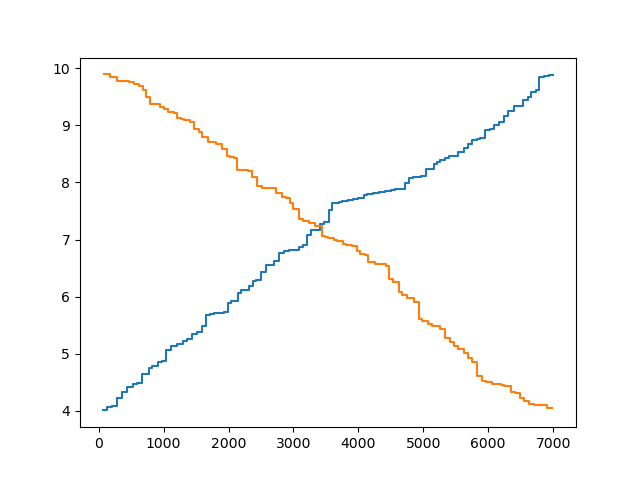

In [10]:
plt.figure()
plt.step(sort_offers["cum_quant"], sort_offers["price"])
plt.step(sort_bidders["cum_quant"], sort_bidders["price"])
plt.show()

## Plot de base

In [11]:
p_opt = [7.24, 10.21, 14.95] 
q_opt = [3476, 3614, 3397]

In [12]:
plt.style.use('seaborn-whitegrid')

<IPython.core.display.Javascript object>


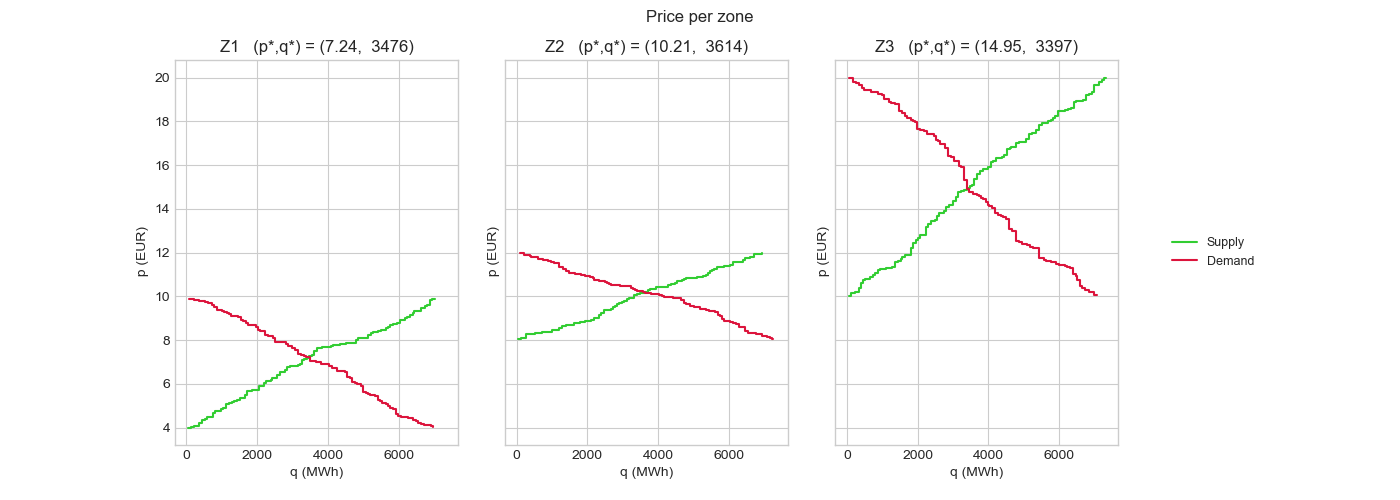

In [13]:
fig, axs = plt.subplots(1, 4, sharex=True,
                        figsize=(14, 5), 
                        gridspec_kw={"width_ratios": [3, 3, 3, 1]}, sharey=True)

for i, p in enumerate(path_list):
        
        
    pax = axs[i]
    df_bid, df_off = proc_df(p)
    
    sort_offers = df_off.sort_values("price")
    sort_offers["cum_quant"] = sort_offers["quantity"].cumsum()
    
    sort_bidders = df_bid.sort_values("price", ascending=False)
    sort_bidders ["cum_quant"] = sort_bidders ["quantity"].cumsum()
    
    
    pax.plot(sort_offers["cum_quant"], 
                sort_offers["price"], ds="steps-post", label="Supply", color="limegreen")
    
    pax.plot(sort_bidders["cum_quant"], 
                sort_bidders["price"], ds="steps-post", label="Demand", color="crimson")
    
    pax.grid(True)
    pax.set_ylabel(" p (EUR)")
    pax.set_xlabel("q (MWh)")
    pax.set_title(f"Z{i+1}   (p*,q*) = ({p_opt[i]},  {q_opt[i]})")
    
    
    
lax = axs[-1]
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)


fig.suptitle("Price per zone")


plt.savefig("price_per_zone.png")


## Marché unique

In [14]:
for p in path_list:
    print(p.parts[-1].split(".")[0])
    df_bid, df_off = proc_df(p)
    uni_optim(df_bid, df_off)
    print("\n")

ZONE_1
Using license file c:\gurobi912\gurobi.lic
Set parameter TokenServer to value dev.cma.mines-paristech.fr
Optimal Cost 10577
Price 7.24


ZONE_2
Optimal Cost 7376
Price 10.21


ZONE_3
Optimal Cost 19197
Price 14.95




## Marchés Couplés

### Capacité d'échange fixe

In [15]:
TAB_CAP = [i for i in range(0,5000, 50)]
ZONE = [i+1 for i in range(len(path_list))]
out_df = pd.DataFrame(columns=ZONE, index=range(len(TAB_CAP)))

In [16]:
d_bid = {i+1 : proc_bid(p) for i, p in enumerate(path_list)}
d_off = {i+1 : proc_off(p) for i, p in enumerate(path_list)}

In [17]:

exchange_keys = [(a,b) for a in ZONE for b in ZONE if a != b]

In [18]:
l_off = tuplelist([(z+1, idx) for z, p in enumerate(path_list) for idx in proc_off(p).index.to_list()])
l_bid = tuplelist([(z+1, idx) for z, p in enumerate(path_list) for idx in proc_bid(p).index.to_list()])


In [19]:
CAP_EX = 0

In [20]:
model = Model()
model.modelSense = GRB.MAXIMIZE


ox = model.addVars(l_off, vtype=GRB.CONTINUOUS, ub=1, name="binary_offers")
bx = model.addVars(l_bid, vtype=GRB.CONTINUOUS, ub=1, name="binary_buyers")
Ex = model.addVars(exchange_keys, vtype=GRB.CONTINUOUS, name="max_exchange")


W = 0 # TOTAL welfare
for z in ZONE:
    bid = quicksum(bx[z,i]*d_bid[z].loc[i]["quantity"]*d_bid[z].loc[i]["price"] for i in d_bid[z].index)
    offer = quicksum(ox[z,j]*d_off[z].loc[j]["quantity"]*d_off[z].loc[j]["price"] for j  in d_off[z].index)
    W += bid - offer

model.addConstrs(Ex[k] <= CAP_EX for k in exchange_keys)    

E_tab = [0]*len(ZONE)
for i, z in enumerate(ZONE):
    E_tab[i] = sum(Ex.select(z,"*")) - sum(Ex.select("*", z))

    
# MAX CAP CONSTRAINT
w_ctrs = []
for idx_z, z in enumerate(ZONE):
    
    tot_bid = quicksum(bx[z,i]*d_bid[z].loc[i]["quantity"] for i in d_bid[z].index)
    tot_off = quicksum(ox[z,j]*d_off[z].loc[j]["quantity"] for j in d_off[z].index)
    w_ctrs.append(model.addConstr(tot_off >= tot_bid + E_tab[idx_z]))
    
model.setObjective(W)

In [21]:
model.update()
model.optimize()
model.setParam('OutputFlag', 0) # Mute output

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9 rows, 606 columns and 618 nonzeros
Model fingerprint: 0x8dde9cee
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 6 rows and 92 columns
Presolve time: 0.02s
Presolved: 3 rows, 514 columns, 514 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1641860e+04   1.668917e+03   0.000000e+00      0s
       3    3.7150256e+04   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  3.715025650e+04


### Itération sur les capacités d'échanges

In [22]:
TAB_CAP = [i for i in range(0,5000, 50)]
out_df = pd.DataFrame(columns=ZONE, index=range(len(TAB_CAP)))
ex_df = pd.DataFrame(columns=exchange_keys, index=range(len(TAB_CAP)))

RENT_TAB = [0]* len(TAB_CAP)

In [23]:
for iter_i, CAP_EX in enumerate(TAB_CAP):
    
    model = Model()
    model.modelSense = GRB.MAXIMIZE


    ox = model.addVars(l_off, vtype=GRB.CONTINUOUS, ub=1, name="binary_offers")
    bx = model.addVars(l_bid, vtype=GRB.CONTINUOUS, ub=1, name="binary_buyers")
    Ex = model.addVars(exchange_keys, vtype=GRB.CONTINUOUS, name="max_exchange")


    W = 0 # TOTAL welfare
    for z in ZONE:
        bid = quicksum(bx[z,i]*d_bid[z].loc[i]["quantity"]*d_bid[z].loc[i]["price"] for i in d_bid[z].index)
        offer = quicksum(ox[z,j]*d_off[z].loc[j]["quantity"]*d_off[z].loc[j]["price"] for j  in d_off[z].index)
        W += bid - offer
        
        
    model.addConstrs(Ex[k] <= CAP_EX for k in exchange_keys)


    E_tab = [0]*3
    for i, z in enumerate(ZONE):
        E_tab[i] = sum(Ex.select(z,"*")) - sum(Ex.select("*", z))


    # MAX CAP CONSTRAINT
    w_ctrs = []
    for idx_z, z in enumerate(ZONE):

        tot_bid = quicksum(bx[z,i]*d_bid[z].loc[i]["quantity"] for i in d_bid[z].index)
        tot_off = quicksum(ox[z,j]*d_off[z].loc[j]["quantity"] for j in d_off[z].index)
        w_ctrs.append(model.addConstr(tot_off >= tot_bid + E_tab[idx_z]))

        
    model.setObjective(W)
    
    
    
    model.update()
    model.setParam('OutputFlag', 0) # Mute output
    model.optimize()
    
    RENT_TAB[iter_i] = quicksum(Ex[i,j]*(-w_ctrs[j-1].getAttr("pi")-  -w_ctrs[i-1].getAttr("pi")) for (i,j) in exchange_keys).getValue()
    out_df.iloc[iter_i] = [-ct.getAttr("pi") for ct in w_ctrs]
    
    for k in exchange_keys:
        ex_df[k].iloc[iter_i] = Ex[k].x
        

<IPython.core.display.Javascript object>


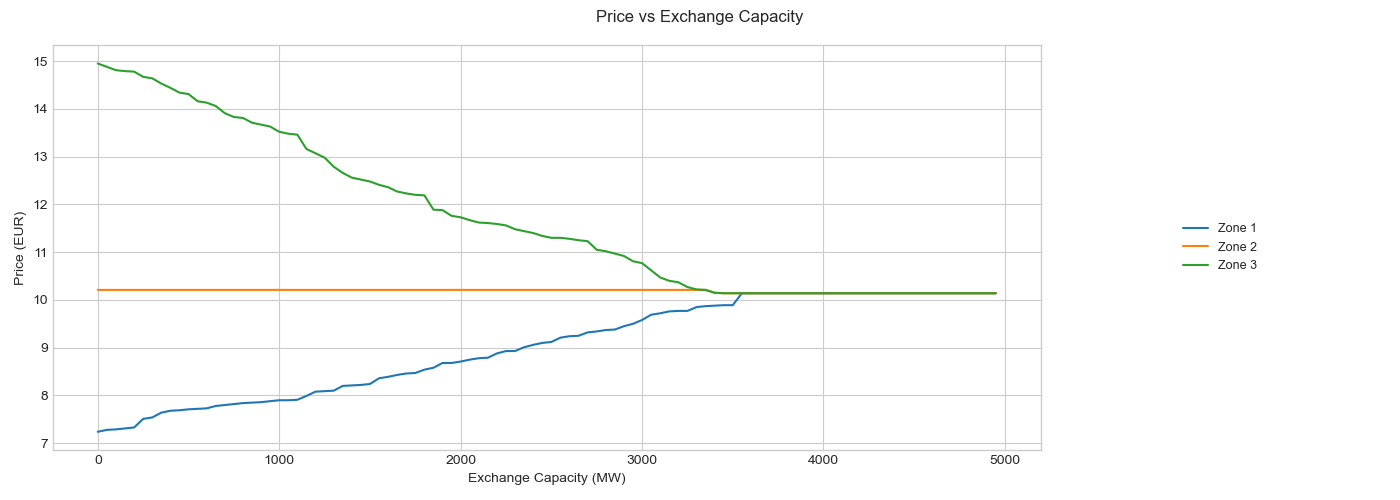

In [24]:
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(14, 5), 
                        gridspec_kw={"width_ratios": [3, 1]}, sharey=True)



pax, lax = axs
for col in out_df.columns:
    pax.plot(TAB_CAP, out_df[col], label=f"Zone {col}")
    lax = axs[-1]
    
    pax.set_ylabel("Price (EUR)")
    pax.set_xlabel("Exchange Capacity (MW)")
    
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)



fig.suptitle("Price vs Exchange Capacity")

plt.savefig("Price vs Exchange Capacity")

fig.tight_layout()

<IPython.core.display.Javascript object>


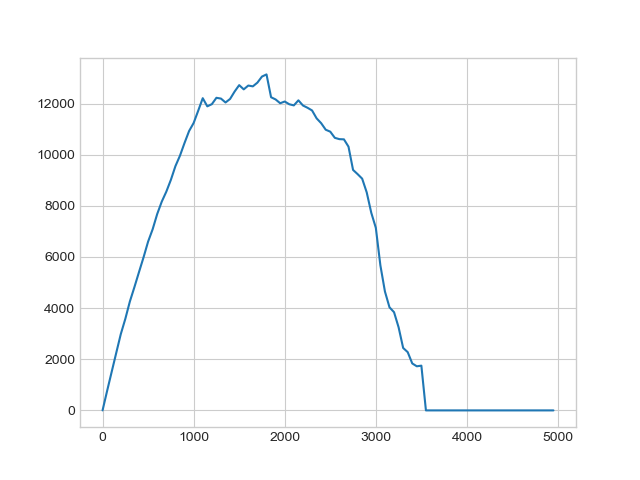

In [25]:
plt.figure()
plt.plot(TAB_CAP, RENT_TAB)

In [26]:
for z in ZONE:
    col_name = str(z) + "_net"
    export_cols = [exprt for exprt in ex_df.columns if exprt[0] == z]
    import_cols = [imprt for imprt in ex_df.columns if imprt[1] == z]
    
    ex_df[col_name] = ex_df[export_cols].sum(axis=1) - ex_df[import_cols].sum(axis=1)

In [27]:
df_plot = ex_df.filter(like="_net")



<IPython.core.display.Javascript object>


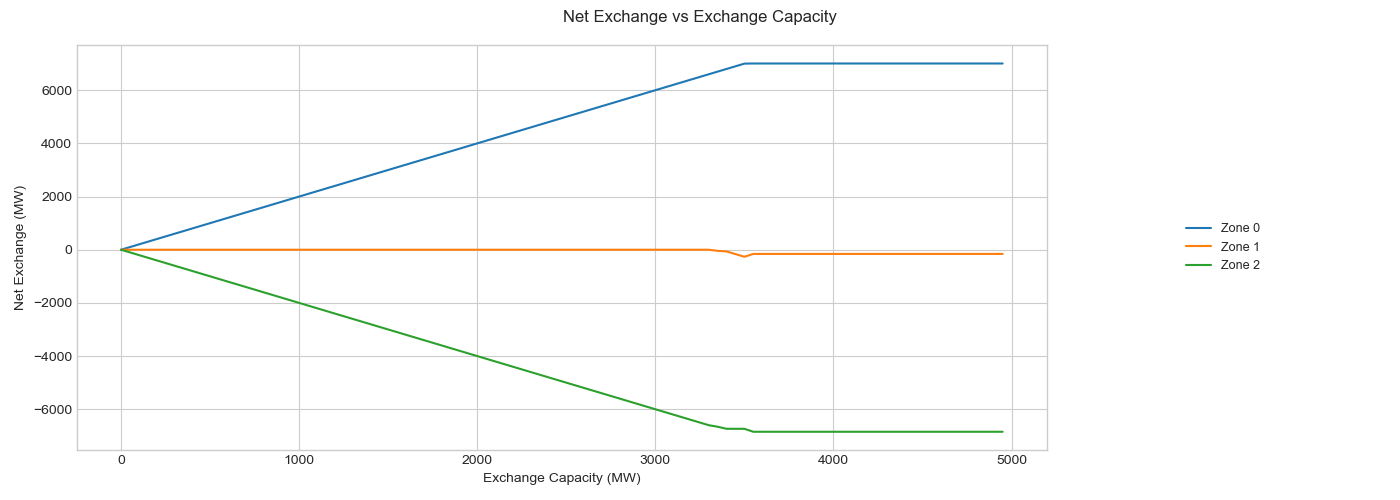

In [28]:
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(14, 5), 
                        gridspec_kw={"width_ratios": [3, 1]}, sharey=True)



pax, lax = axs
for i, col in enumerate(df_plot.columns):
    pax.plot(TAB_CAP, df_plot[col], label=f"Zone {i}")
    lax = axs[-1]
    
    pax.set_ylabel("Net Exchange (MW)")
    pax.set_xlabel("Exchange Capacity (MW)")
    
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

fig.suptitle("Net Exchange vs Exchange Capacity")

plt.savefig("Net Exchange vs Exchange Capacity")

fig.tight_layout()



save_path = r"net_exchange_vs_capacity"
plt.savefig(save_path)

In [29]:
TAB_CAP[71]

3550

## Modélisation plaque européenne 35 zones

In [30]:
col_names = ["q_off", "p_off", "q_bid", "p_bid"]

In [32]:
# Voir slides pour commentaires
list_df = [0]*35
for i in range(0,35):
    vente_q = np.random.normal(2000*(1+i/35), np.sqrt(35/(i+1)), 100)
    vente_p = np.random.normal(i, np.sqrt(i), 100)
    bid_q = np.random.normal(2000*(1+i/35), np.sqrt(35/(i+1)), 100)
    bid_p = np.random.normal(i, np.sqrt(i), 100)
    list_df[i] = pd.DataFrame(data = list(zip(vente_q, vente_p, bid_q, bid_p)), columns = col_names)
for df in list_df:
    for col in df.columns:
        df[col].loc[df[col]<=0] = df[col].mean()

In [33]:
d_bid = {i+1 : list_df[i].filter(like="bid") for i in range(len(list_df))}
d_off = {i+1 : list_df[i].filter(like="off") for i in range(len(list_df))}

In [34]:
ZONE = [i+1 for i in range(len(list_df))]
exchange_keys = [(a,b) for a in ZONE for b in ZONE if a != b]


CAP_EX = 0

l_off = tuplelist([(z+1, idx) for z, p in enumerate(ZONE) for idx in list_df[z].filter(like="off").index.to_list()])
l_bid = tuplelist([(z+1, idx) for z, p in enumerate(ZONE) for idx in list_df[z].filter(like="bid").index.to_list()])


CAP_EX = 14000

model = Model()
model.modelSense = GRB.MAXIMIZE


ox = model.addVars(l_off, vtype=GRB.CONTINUOUS, ub=1, name="binary_offers")
bx = model.addVars(l_bid, vtype=GRB.CONTINUOUS, ub=1, name="binary_buyers")
Ex = model.addVars(exchange_keys, vtype=GRB.CONTINUOUS, name="max_exchange")


W = 0 # TOTAL welfare
for z in ZONE:
    bid = quicksum(bx[z,i]*d_bid[z].loc[i]["q_bid"]*d_bid[z].loc[i]["p_bid"] for i in d_bid[z].index)
    offer = quicksum(ox[z,j]*d_off[z].loc[j]["q_off"]*d_off[z].loc[j]["p_off"] for j  in d_off[z].index)
    W += bid - offer

model.addConstrs(Ex[k] <= CAP_EX for k in exchange_keys)    

E_tab = [0]*len(list_df)
for i, z in enumerate(ZONE):
    E_tab[i] = sum(Ex.select(z,"*")) - sum(Ex.select("*", z))

    
# MAX CAP CONSTRAINT
w_ctrs = []
for idx_z, z in enumerate(ZONE):
    
    tot_bid = quicksum(bx[z,i]*d_bid[z].loc[i]["q_bid"] for i in d_bid[z].index)
    tot_off = quicksum(ox[z,j]*d_off[z].loc[j]["q_off"] for j in d_off[z].index)
    w_ctrs.append(model.addConstr(tot_off >= tot_bid + E_tab[idx_z]))
    
model.setObjective(W)

model.update()
model.optimize()
model.setParam('OutputFlag', 0) # Mute output

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1225 rows, 8190 columns and 10570 nonzeros
Model fingerprint: 0xbb502d70
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+04, 1e+04]
Presolve removed 1190 rows and 837 columns
Presolve time: 0.02s
Presolved: 35 rows, 7353 columns, 7948 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6812288e+08   2.840069e+05   0.000000e+00      0s
     199    9.3772106e+07   0.000000e+00   0.000000e+00      0s

Solved in 199 iterations and 0.03 seconds
Optimal objective  9.377210564e+07


In [ ]:
TAB_CAP = [i for i in range(0,18000, 100)]
out_df = pd.DataFrame(columns=ZONE, index=range(len(TAB_CAP)))
ex_df = pd.DataFrame(columns=exchange_keys, index=range(len(TAB_CAP)))

RENT_TAB = [0]* len(TAB_CAP)

for iter_i, CAP_EX in enumerate(TAB_CAP):
    
    model = Model()
    model.modelSense = GRB.MAXIMIZE

    
    if iter_i%10 == 0:
        print(f"Iteration {iter_i}")

    ox = model.addVars(l_off, vtype=GRB.CONTINUOUS, ub=1, name="binary_offers")
    bx = model.addVars(l_bid, vtype=GRB.CONTINUOUS, ub=1, name="binary_buyers")
    Ex = model.addVars(exchange_keys, vtype=GRB.CONTINUOUS, name="max_exchange")


    W = 0 # TOTAL welfare
    for z in ZONE:
        bid = quicksum(bx[z,i]*d_bid[z].loc[i]["q_bid"]*d_bid[z].loc[i]["p_bid"] for i in d_bid[z].index)
        offer = quicksum(ox[z,j]*d_off[z].loc[j]["q_off"]*d_off[z].loc[j]["p_off"] for j  in d_off[z].index)
        W += bid - offer

    model.addConstrs(Ex[k] <= CAP_EX for k in exchange_keys)    

    E_tab = [0]*len(list_df)
    for i, z in enumerate(ZONE):
        E_tab[i] = sum(Ex.select(z,"*")) - sum(Ex.select("*", z))


    # MAX CAP CONSTRAINT
    w_ctrs = []
    for idx_z, z in enumerate(ZONE):

        tot_bid = quicksum(bx[z,i]*d_bid[z].loc[i]["q_bid"] for i in d_bid[z].index)
        tot_off = quicksum(ox[z,j]*d_off[z].loc[j]["q_off"] for j in d_off[z].index)
        w_ctrs.append(model.addConstr(tot_off >= tot_bid + E_tab[idx_z]))

    model.setObjective(W)

    model.update()
    model.setParam('OutputFlag', 0) # Mute output
    model.optimize()
    
    RENT_TAB[iter_i] = quicksum(Ex[i,j]*(-w_ctrs[j-1].getAttr("pi")-  -w_ctrs[i-1].getAttr("pi")) for (i,j) in exchange_keys).getValue()
    out_df.iloc[iter_i] = [-ct.getAttr("pi") for ct in w_ctrs]
    
    for k in exchange_keys:
        ex_df[k].iloc[iter_i] = Ex[k].x
        

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(14, 8), 
                        gridspec_kw={"width_ratios": [3, 1]}, sharey=True)



pax, lax = axs
for col in out_df.columns:
    pax.plot(TAB_CAP, out_df[col], label=f"Zone {col}")
    lax = axs[-1]
    
    pax.set_ylabel("Price (EUR)")
    pax.set_xlabel("Exchange Capacity (MW)")
    
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)



fig.suptitle("Price vs Exchange Capacity 35 ZONES")

plt.savefig("Price vs Exchange Capacity 35 ZONES")

fig.tight_layout()

In [ ]:

fig, axs = plt.subplots(1, 2, sharex=True,
                            figsize=(14, 5), 
                            gridspec_kw={"width_ratios": [3, 1]}, sharey=True)


pax, lax = axs
    
    


pax.plot(TAB_CAP[:], RENT_TAB[:], label=f"Emax = {round((TAB_CAP[74]))} \n R ={round(RENT_TAB[74])} EUR")
lax = axs[-1]

pax.set_ylabel("Revenue (EUR.MW)")
pax.set_xlabel("Exchange Capacity (MW)")

    
pax.set_xlim(0, TAB_CAP[-1]+1000)
pax.set_ylim(0, 40000000)
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

    
fig.suptitle("Revenue Vs Capacity Exchange 35 ZONES")


save_path = r"revenue_vs_capacity 35 ZONES MAX"
plt.savefig(save_path)

fig.tight_layout()

**END OF NOTEBOOK**